# Praktikum 3: tehisnärvivõrgud (1)

## Sissejuhatus

Tehisnärvivõrk on iseõppiv süsteem, mille eeskujuks on inimaju ehitus.

Tehisnärvivõrgu koostisosad:  
* Sisendkiht (x) (*Input layer*)
* Peidetud kihid (*Hidden layer*)
* Väljundkiht ($\hat{y}$) (*Output layer*)
* Iga kihi kohta kaalud ja vabaliikmed (*W* ja *b*) (tavaliselt räägitakse lihtsalt kihi kaaludest, kus vabaliige on ka üks kaal (*Weights 1 & 2*)).
* Kihtide aktiveerimisfunktsioonid (*$\sigma$*). 

Diagramm näitab 2-kihilise tehisnärvivõrgu arhitektuuri (tavaliselt me sisendkihti ei loe eraldi kihiks)
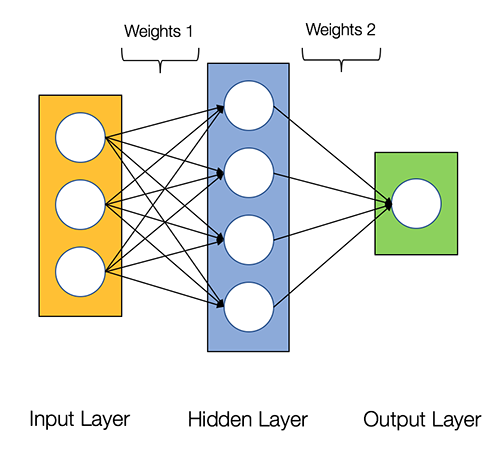

Võimalus katsetada simulatsiooni: https://playground.tensorflow.org/

## Moodul "Keras"

[Keras](https://keras.io/) on (sügava) tehisnärvivõrgu (deep learning) teek Pythonis, mis lihtsustab tehisnärvivõrkudega seotud õppimist ja kasutamist. Kerasel on väga hea kasutajaliides koos minimalistliku modulaarse disainiga, mis tekitab tunde, et tehisnärvivõrkudega töötamine on kergem kui tegelikult.

Impordime vajalikud moodulid.

In [ ]:
import itertools

# Numpy
import numpy as np

# Keras
from keras.layers import Dense, Input, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD

# Pandas
import pandas as pd

# Sklearn
import sklearn.preprocessing
import sklearn.utils

# Visualiseerimine
import matplotlib.pyplot as plt
%matplotlib inline

## Esimene mudel

### Andmed

Taas on meil vaja andmeid ning nagu alati: mida rohkem, seda parem. Momendil püüame õpetada mudelile loogilist tehet [XOR](https://et.wikipedia.org/wiki/V%C3%A4listav_disjunktsioon): anname X-hulgana kolme muutuja erinevad väärtustused (1 või 0 ehk True või False) ja y-hulgana XOR-tehte tulemused. 

Igaks juhuks juba ette: me proovime meetodit, aga me ei jõua mõistlike tulemusteni. ;) 

In [ ]:
X = np.array(list(itertools.product([False, True], repeat=3)), dtype=np.int)
y = np.bitwise_xor(np.bitwise_xor(X[:,0], X[:,1]), X[:,2])
print(X)
print(y)
print()

for x_val, y_val in zip(X, y):
    print(x_val, "->", y_val)

[[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
[0 1 1 0 1 0 0 1]

[0 0 0] -> 0
[0 0 1] -> 1
[0 1 0] -> 1
[0 1 1] -> 0
[1 0 0] -> 1
[1 0 1] -> 0
[1 1 0] -> 0
[1 1 1] -> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


### Mudeli loomine
Natuke on abiks [Keras cheat sheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf)

Teeme alustuseks lihtsa mudeli, kus on meil peale sisendi peidetud 4 neuroniga kiht ja väljundkiht. Kerases kutsutakse neid kihte [Dense](https://keras.io/layers/core/#dense)-kihtideks.

In [ ]:
mdl = Sequential() 

mdl.add(Dense(4, activation="sigmoid", input_shape=(X.shape[1],)))
mdl.add(Dense(1, activation="sigmoid"))

mdl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 16        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


#### Ülesanne
Miks meil on 16 parameetrit? Meil on sisendi suuruseks 3 ja kiht koosneb 4 neuronist, seega peaks meil ju olema kaalude maatriks (3, 4) ehk 12 parameetrit? 

In [ ]:
# Mudeli kaalud
mdl.weights

[<tf.Variable 'dense/kernel:0' shape=(3, 4) dtype=float32, numpy=
 array([[ 0.6476953 , -0.7314312 ,  0.2095058 ,  0.35438323],
        [-0.0473699 , -0.35087937,  0.08949161,  0.7190957 ],
        [-0.2609756 , -0.8231845 , -0.20644426, -0.06995416]],
       dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(4, 1) dtype=float32, numpy=
 array([[ 0.27541947],
        [-0.8777455 ],
        [-1.064186  ],
        [-0.62554765]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

### Kaofunktsioon (kadu, *loss*)

Meil on vaja hinnata, kui hea on meie mudel, sest me ei oska muidu kuidagi kaale muuta. Selle jaoks on kaofunktsioon, mis ütleb, kui valesti meie algoritm ennustab, et neurovõrk saaks kaale muuta ja uuesti proovida. Nii püüab neurovõrk kogu treenimise käigus kaofunktsiooni väärtust minimeerida. 

Kaofunktsioone on olemas palju ja nende hulgast peab valima sobiva vastavalt ülesande püstitusele.  

Lühike ülevaade kaofunktsioonidest: https://medium.com/data-science-group-iitr/loss-functions-and-optimization-algorithms-demystified-bb92daff331c

Lisame enda mudelile kaofunktsiooni.

In [ ]:
opt = SGD(learning_rate=1, decay=0, momentum=0)
mdl.compile(loss='mean_squared_error', optimizer=opt)

### Treenimine
Treenimine on iteratiivne protsess, mis koosneb järgnevatest sammudest: 
* Ennustamine ehk $\hat{y}$ arvutamine, mida kutsutakse **pärileviks** (*Feedforward* / *Forward pass*)
* Kaalude (W, b) uuendamine, kutsutakse **tagasileviks** (*Backpropagation*)

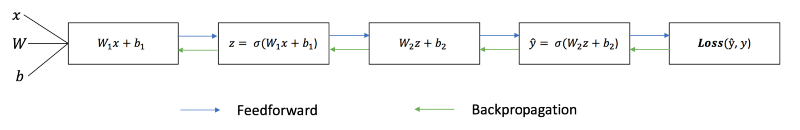

In [ ]:
hist = mdl.fit(X, y, epochs=4000, batch_size=8, verbose=False)

### Ennustamine ja hindamine

In [ ]:
y_pred = mdl.predict(X)
y_pred

array([[0.04350761],
       [0.93662643],
       [0.97187185],
       [0.04995304],
       [0.943593  ],
       [0.02991399],
       [0.06388997],
       [0.94687533]], dtype=float32)

In [ ]:
for y_pred_val, y_val in zip(y_pred, y):
    print(y_pred_val, "-", y_val)

[0.04350761] - 0
[0.93662643] - 1
[0.97187185] - 1
[0.04995304] - 0
[0.943593] - 1
[0.02991399] - 0
[0.06388997] - 0
[0.94687533] - 1


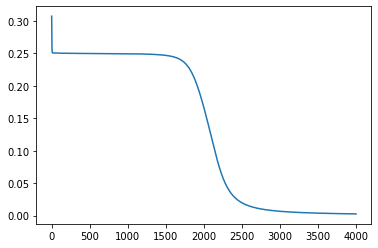

In [ ]:
plt.plot(hist.history["loss"])

## "Pärisandmed"
Võtame ette andmebaasi teemanditega (diamonds.csv). 

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/ai")

Mounted at /content/drive


In [ ]:
failinimi = 'diamonds.csv'
teemandid = pd.read_csv(failinimi, delimiter=",")
tunnused = [i for i in teemandid]
print(tunnused)

['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']


#### Ülesanne
Uurime andmeid: trükime ekraanile mõõtmed, vaatame esimesi ridu ja teeme statistilist analüüsi.

In [ ]:
teemandid.shape

(53940, 11)

In [ ]:
teemandid.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
teemandid.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,26970.500000,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


### Eeltöötlus 
Vaatame, millised on meie andmed.

#### Ülesanne

- Kui palju on kirjeid?
- Kui palju on puuduvaid andmeid?
- Mis tüüpi on andmed?
- Kas andmed on järjestatud?

In [ ]:
teemandid.isnull().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

### Andmete juhuslik järjestamine

In [ ]:
teemandid = sklearn.utils.shuffle(teemandid)

### Puuduvad andmed

Nagu varasemate masinõppemeetodite puhul on parem täita tühjad lahtrid sobivate väärtustega. Selleks saab kasutada samu võtteid, mida me juba varasemates praktikumides oleme vaadanud (keskmine väärtus, sagedaseim väärtus, "muu" vms). 

### Normaliseerimine 
Nagu varemgi, püüame normaliseerida arvuliste andmetega tunnused: paigutame iga tunnuse puhul eraldi väärtused 0 ja 1 vahele. Võime seda teha näiteks scikit-learni eeltöötlusvahendiga MinMaxScaler (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

#### Ülesanne
Normaliseerime kõik arvuliste andmetega tunnuste väärtused, seda võib teha nii samadesse tulpadesse kui uutesse.

In [ ]:
teemandid.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
20763,20764,1.01,Very Good,E,VVS2,61.5,58.0,9002,6.40,6.44,3.95
668,669,0.77,Premium,E,SI1,62.9,59.0,2846,5.84,5.79,3.66
43377,43378,0.50,Premium,F,SI1,62.5,59.0,1409,5.03,4.99,3.13
43461,43462,0.51,Very Good,F,VS2,63.2,58.0,1417,5.07,5.05,3.20
14346,14347,1.22,Ideal,I,SI1,62.6,57.0,5807,6.80,6.77,4.25


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = sklearn.preprocessing.MinMaxScaler()
teemandid[["carat", "depth", "table", "x", "y", "z", "price"]] = scaler.fit_transform(teemandid[["carat", "depth", "table", "x", "y", "z", "price"]])

teemandid.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
20763,20764,0.168399,Very Good,E,VVS2,0.513889,0.288462,0.469049,0.595903,0.109338,0.124214
668,669,0.118503,Premium,E,SI1,0.552778,0.307692,0.136238,0.543762,0.098302,0.115094
43377,43378,0.062370,Premium,F,SI1,0.541667,0.307692,0.058550,0.468343,0.084720,0.098428
43461,43462,0.064449,Very Good,F,VS2,0.561111,0.288462,0.058983,0.472067,0.085739,0.100629
14346,14347,0.212058,Ideal,I,SI1,0.544444,0.269231,0.296318,0.633147,0.114941,0.133648


### Konverteerimine
Tehisnärvivõrgud kasutavad vaid arvulisi andmeid, seega peame näiteks tekstilised andmed, mille mudelisse valime, teisendama arvulisteks. Üheks variandiks on taas 1-hot vektor (vt. varasemaid praktikume).

Praegusel töölehel kasutame oma mudelis vaid juba algselt arvulisi andmeid. 

### Vajalike tunnuste eraldamine
Oletame, et soovime teiste arvuliste tunnuste põhjal ennustada teemandi hinda, selleks eraldame andmetest vaid vajalikud tulbad.

In [ ]:
# Valime tunnusteks arvulised andmed
# NB! Kui normaliseerimistulemused said uude tulpa, siis kasutage neid!
X = teemandid[["carat", "depth", "table", "x", "y", "z"]]
y = teemandid[["price"]]
#print(y)

### Mudel
Kasutame kõigepealt juba varem loodud närvivõrku ning koostame selle ja uute andmete põhjal uue mudeli

In [ ]:
mdl = Sequential() 

mdl.add(Dense(4, activation="sigmoid", input_shape=(X.shape[1],)))
mdl.add(Dense(1, activation="sigmoid"))

mdl.summary()

# Lisame mudelile kaofunktsiooni
opt = SGD(learning_rate=1, decay = 0, momentum=0)
mdl.compile(loss='mean_squared_error', optimizer=opt)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4)                 28        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


Treenime seda...

In [21]:
hist = mdl.fit(X, y, epochs=10, batch_size=8, verbose=True)

Epoch 1/10
6743/6743 [==============================] - 18s 3ms/step - loss: 0.0095
Epoch 2/10
6743/6743 [==============================] - 29s 4ms/step - loss: 0.0062
Epoch 3/10
6743/6743 [==============================] - 15s 2ms/step - loss: 0.0061
Epoch 4/10
6743/6743 [==============================] - 19s 3ms/step - loss: 0.0061
Epoch 5/10
6743/6743 [==============================] - 15s 2ms/step - loss: 0.0061
Epoch 6/10
6743/6743 [==============================] - 15s 2ms/step - loss: 0.0061
Epoch 7/10
6743/6743 [==============================] - 15s 2ms/step - loss: 0.0061
Epoch 8/10
6743/6743 [==============================] - 16s 2ms/step - loss: 0.0061
Epoch 9/10
6743/6743 [==============================] - 16s 2ms/step - loss: 0.0061
Epoch 10/10
6743/6743 [==============================] - 24s 4ms/step - loss: 0.0061


... ja testime kaofunktsiooni poolt juba treenimise ajal tagastatud tulemuste põhjal.

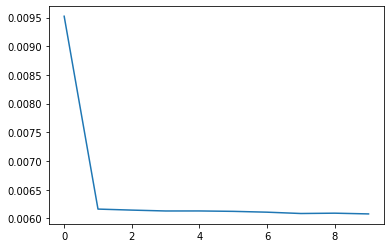

In [22]:
plt.plot(hist.history["loss"])

### Testhulga eraldamine
Me võime mudelile ette anda ka nn. valideerimishulga, mis ei kattu treeningandmetega ja mille alusel ta hindab kao väärtust. Kõik toimub analoogselt varasemate praktikumidega. 

Loeme andmed uuesti sisse. Momendil teeme seda puhtalt sel põhjusel, et saaksime meenutada andmete eeltöötlust juhul, kui testhulk on eraldatud juba enne eeltöötluse tegemist: normaliseerimisparameetrid leiame ainult treeninghulgal ja rakendame testhulga normaliseerimisel just neid jne. 

In [34]:
teemandid = pd.read_csv(failinimi, delimiter=",")

X = teemandid[["carat", "depth", "table", "x", "y", "z"]]
y = teemandid[["price"]]
print(y)

       price
0        326
1        326
2        327
3        334
4        335
...      ...
53935   2757
53936   2757
53937   2757
53938   2757
53939   2757

[53940 rows x 1 columns]


Jagame treening- ja testhulgaks juba varem nähtud meetodit kasutades.

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
print(X_train.shape)
print(y_train.shape)

(43152, 6)
(43152, 1)


Vaatame enne andmete normaliseerimist korraks kaaluandmete (*carat*) äärmusi (miinimumi ja maksimumi) nii treening- kui testhulgal, et saaksime pärast normaliseerimist tulemusi võrrelda.

In [36]:
print("Minimaalne kaal treeninghulgal:", X_train['carat'].min())
print("Minimaalne kaal testhulgal:", X_test['carat'].min())

print("Maksimaalne kaal treeninghulgal:", X_train['carat'].max())
print("Maksimaalne kaal testhulgal:", X_test['carat'].max())

Minimaalne kaal treeninghulgal: 0.2
Minimaalne kaal testhulgal: 0.2
Maksimaalne kaal treeninghulgal: 4.5
Maksimaalne kaal testhulgal: 5.01


Teeme eeltöötlust enne treeninghulgale (fit_transform), seejärel kasutame treeinghulgal õpetatud skaleerijat testhulgal (ainult transform!), sest soovime saada treeninghulga väärtuste samasugust teisendust.

In [37]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler_y = sklearn.preprocessing.MinMaxScaler()

X_train[["carat", "depth", "table", "x", "y", "z"]] = scaler.fit_transform(X_train[["carat", "depth", "table", "x", "y", "z"]])
y_train[["price"]] = scaler_y.fit_transform(y_train[["price"]])

X_test[["carat", "depth", "table", "x", "y", "z"]] = scaler.transform(X_test[["carat", "depth", "table", "x", "y", "z"]])
y_test[["price"]] = scaler_y.transform(y_test[["price"]])

Vaatame kaaluandmete (*carat*) äärmusi (miinimumi ja maksimumi) nii treening- kui testhulgal pärast normaliseerimist. Paneme tähele, et kui treeninghulgal X_train saadud MinMaxScaler *scaler* annab treeningandmete miinimumiks 0 ja maksimumiks 1 (see peabki vastavalt eesmärgile nii olema), siis testhulgast leiti praeguse jaotuse korral suurem teemant ning selle kaalu väärtus pärast normaliseerimist on suurem kui 1.

In [38]:
print("Pärast normaliseerimist:")

print("Minimaalne kaal treeninghulgal:", X_train['carat'].min())
print("Minimaalne kaal testhulgal:", X_test['carat'].min())

print("Maksimaalne kaal treeninghulgal:", X_train['carat'].max())
print("Maksimaalne kaal testhulgal:", X_test['carat'].max())

Pärast normaliseerimist:
Minimaalne kaal treeninghulgal: 0.0
Minimaalne kaal testhulgal: 0.0
Maksimaalne kaal treeninghulgal: 1.0
Maksimaalne kaal testhulgal: 1.1186046511627905


#### Ülesanne

Eraldage andmetest testhulk (20% kõigist), mida kasutatakse mudeli loomisel mudeli valideerimisel, ja andke see treenimisel ette lisaks eelmistele veel ühe parameetrina (validation_data = (X_test, y_test)).

In [39]:
mdl = Sequential() 

mdl.add(Dense(4, activation="sigmoid", input_shape=(X.shape[1],)))
mdl.add(Dense(1, activation="sigmoid"))

mdl.summary()

opt = SGD(learning_rate=1, decay = 0, momentum=0)
mdl.compile(loss='mean_squared_error', optimizer=opt)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 4)                 28        
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [40]:
hist = mdl.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=8, verbose=True)

Epoch 1/10
5394/5394 [==============================] - 12s 2ms/step - loss: 0.0103 - val_loss: 0.0072
Epoch 2/10
5394/5394 [==============================] - 12s 2ms/step - loss: 0.0061 - val_loss: 0.0066
Epoch 3/10
5394/5394 [==============================] - 12s 2ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 4/10
5394/5394 [==============================] - 12s 2ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 5/10
5394/5394 [==============================] - 11s 2ms/step - loss: 0.0061 - val_loss: 0.0066
Epoch 6/10
5394/5394 [==============================] - 11s 2ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 7/10
5394/5394 [==============================] - 12s 2ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 8/10
5394/5394 [==============================] - 11s 2ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 9/10
5394/5394 [==============================] - 12s 2ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 10/10
5394/5394 [==============================] - 12s 2ms/step - l

Vaatame kaofunktsiooni tulemusi nii treening- kui ka valideerimishulgal. 

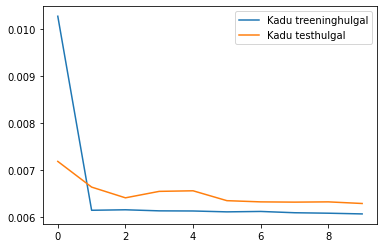

In [41]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.legend(['Kadu treeninghulgal', 'Kadu testhulgal'], loc='upper right')

### Ülesanne
Kas kaofunktsioonide graafikud on ootuspärased? Kas midagi üllatab? 

### Keerulisem mudel
Lisame oma mudelile teistsugused kihid. Kihtide ja nende parameetrite valik on põhiline keerukus tehisnärvivõrkude ehitamisel, väga üldisi soovitusi võib lugeda näiteks https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/. 

In [42]:
mdl = Sequential()

mdl.add(Dense(64, activation="tanh", input_shape=(X_train.shape[1],)))
mdl.add(BatchNormalization())
mdl.add(Dense(32, activation="tanh"))
mdl.add(BatchNormalization())
mdl.add(Dense(16, activation="selu"))
mdl.add(BatchNormalization())
mdl.add(Dense(7, activation="linear"))
mdl.add(Dense(1, activation="linear"))

mdl.compile(loss='mean_squared_error', optimizer="adam")

In [43]:
mdl.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                448       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 batch_normalization_2 (Batc  (None, 16)              

#### Ülesanne
Treenime uut mudelit, andes ette eraldi nii treening- kui testhulgad nagu eelmises ülesandes. Suurendame ka hulga suurust, mida korraga töötlusesse saadetakse (*batch_size*) (https://keras.io/models/sequential/), mille väärtus vaikimisi on 32. Mida suurem selle väärtus on, seda kiirem on töö, kuid seda rohkem nõuab mälu. Valime selle parameetri suuruseks 256.

In [52]:
hist = mdl.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=256)

Epoch 1/40
169/169 [==============================] - 1s 5ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 2/40
169/169 [==============================] - 1s 5ms/step - loss: 0.0062 - val_loss: 0.0129
Epoch 3/40
169/169 [==============================] - 1s 5ms/step - loss: 0.0061 - val_loss: 0.0075
Epoch 4/40
169/169 [==============================] - 1s 5ms/step - loss: 0.0062 - val_loss: 0.0103
Epoch 5/40
169/169 [==============================] - 1s 5ms/step - loss: 0.0062 - val_loss: 0.0099
Epoch 6/40
169/169 [==============================] - 1s 5ms/step - loss: 0.0061 - val_loss: 0.0087
Epoch 7/40
169/169 [==============================] - 1s 5ms/step - loss: 0.0062 - val_loss: 0.0096
Epoch 8/40
169/169 [==============================] - 1s 5ms/step - loss: 0.0061 - val_loss: 0.0106
Epoch 9/40
169/169 [==============================] - 1s 5ms/step - loss: 0.0060 - val_loss: 0.0069
Epoch 10/40
169/169 [==============================] - 1s 5ms/step - loss: 0.0060 - val_loss: 0.0073

Vaatame tulemusi, kasutades selleks väikest abifunktsiooni.

In [54]:
# Abifunktsioon diagrammi tegemiseks
def plot_loss(history, skip_first=0):
    plt.plot(history.history['loss'][skip_first:])
    plt.plot(history.history['val_loss'][skip_first:])
    plt.ylabel('Kadu')
    plt.xlabel('Epohh')
    plt.legend(['Treening', 'Test'], loc='upper right')
    plt.show()

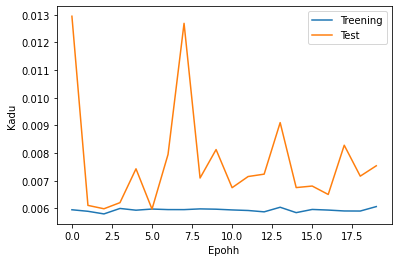

In [55]:
plot_loss(hist, skip_first=20)

In [47]:
print('coolcoolcool')

coolcoolcool
